# User's Guide, Chapter 21: Ordering and Sorting of Stream Elements

Inside a stream, each object has a position and thus an order in the :class:`~music21.stream.Stream`.  Up until now we've seen two different ways to describe the position of an element (such as a :class:`~music21.note.Note`) in a stream.  The first is the index of the object in the stream (a number in square brackets) and the second is the `offset`.

Let's take a simple Stream:

In [1]:
from music21 import *
s = stream.Measure()
ts1 = meter.TimeSignature('3/4')
s.insert(0, ts1)
s.insert(0, key.KeySignature(2))
s.insert(0, clef.TrebleClef())
s.insert(0, note.Note('C#4'))
s.insert(1, note.Note('D#4'))

We have inserted three elements that take up no space (a TimeSignature, KeySignature, and a Clef) and two elements that take up 1.0 quarter notes (the default length of a Note object). You might notice that the signatures and clef were inserted in a strange order. Don't worry, we'll get to that in a bit.  

In addition to inserting elements at particular places in a Stream, we can append an element to the end of the Stream:

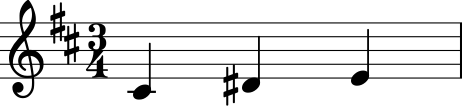

In [2]:
e = note.Note('E4')
s.append(e)
s.show()

Now we're pretty sure that the C# will be the fourth element in the Stream, which is referred to as `[3]` and the D# will be the fifth, or `[4]`

In [3]:
s[3]

<music21.note.Note C#>

In [4]:
s[4]

<music21.note.Note D#>

The E will be `[5]` but we can also get it by saying it's the last element, or `[-1]`

In [5]:
s[-1]

<music21.note.Note E>

The other way to describe the position of an element is by its offset.

In [6]:
e.offset

2.0

You may recall from previous discussions that the `offset` of an element is its position within the last referenced Stream it was attached to.  Thus, if you want to know the offset of an element within a particular Stream, it is always safer to use one the following methods: `.getOffsetBySite(stream)`: 

In [7]:
e.getOffsetBySite(s)

2.0

Or to call `stream.elementOffset(element)`. This is a little bit faster so it's what we use internally. It will always give the same result if `e` is in `s`, but if `e` might not be in `s` but be derived from an element in `s` then `.getOffsetBySite` will trace the `.derivation.chain()` to find it.

In [8]:
s.elementOffset(e)

2.0

If you want to find all the elements at a particular offset, call `.getElementsByOffset` on the Stream.  Note that if any elements are found it returns a `StreamIterator`, so you will need to use the square bracket index to reference it:

In [9]:
s.getElementsByOffset(2.0)[0]

<music21.note.Note E>

This description might seem a bit obnoxious, but it is necessary because you can get multiple elements back, such as with an offset range:

In [10]:
y = s.getElementsByOffset(1.0, 3.0)
(y[0], y[1])

(<music21.note.Note D#>, <music21.note.Note E>)

At this point, you might think that you know everything about how elements are positioned in a Stream, but there are a few more points that are important and point to the power of `music21`.  Let's show the Stream as a text file:

In [11]:
s.show('text')

{0.0} <music21.clef.TrebleClef>
{0.0} <music21.key.KeySignature of 2 sharps>
{0.0} <music21.meter.TimeSignature 3/4>
{0.0} <music21.note.Note C#>
{1.0} <music21.note.Note D#>
{2.0} <music21.note.Note E>


Something has happened: the `TrebleClef` object which was inserted third has now become the first element of the Stream. The `KeySignature` and `TimeSignature` objects have also switched position.  Now all three are in the order we'd expect to see them in a score:

In [12]:
(s[0], s[1], s[2])

(<music21.clef.TrebleClef>,
 <music21.key.KeySignature of 2 sharps>,
 <music21.meter.TimeSignature 3/4>)

Even though they have the same `.offset`, each of these objects knows its place in the Stream, because of something called `.classSortOrder`.  Each Class and each instance of the class has a default sort order so that if it is at the same offset as a member of a different class, one will sort before the other:

In [13]:
(s[0].classSortOrder, s[1].classSortOrder, s[2].classSortOrder)

(0, 2, 4)

In fact, `classSortOrder` is present not just on objects but on classes:

In [14]:
(clef.Clef.classSortOrder, key.KeySignature.classSortOrder, meter.TimeSignature.classSortOrder)

(0, 2, 4)

Notes have a higher `classSortOrder` and thus sort even later, hence why the C# appears after the clefs and signatures:

In [15]:
(note.Note.classSortOrder, base.Music21Object.classSortOrder)

(20, 20)

There are a few elements that sort even lower than Clefs because they usually refer to the area of the composition that precedes the clef:

In [16]:
(bar.Barline.classSortOrder, instrument.Instrument.classSortOrder, metadata.Metadata.classSortOrder)

(-5, -25, -30)

The numbers are actually completely arbitrary (it could be -6.432 instead of -5), only the order of numbers (-25 is less than -5) matters.

If we put a second TimeSignature into the stream at offset 0 (like some pieces do with multiple interpretations for meter), it will have a tie for its .offset and .classSortOrder.  Which one will come first? It's the first one inserted:

In [17]:
ts2 = meter.TimeSignature('6/8')
s.insert(0, ts2)
s.show('text')

{0.0} <music21.clef.TrebleClef>
{0.0} <music21.key.KeySignature of 2 sharps>
{0.0} <music21.meter.TimeSignature 3/4>
{0.0} <music21.meter.TimeSignature 6/8>
{0.0} <music21.note.Note C#>
{1.0} <music21.note.Note D#>
{2.0} <music21.note.Note E>


If we wanted to make sure that the two TimeSignatures appeared in a particular order regardless of when they were inserted, there is one way to do so: set the `.priority` attribute on the TimeSignature.  Every Music21Object has a `priority` attribute, and the default is `0`. Negative numbers make an element sort before a default element. Positive numbers sort after.  

Let us insert two more notes into the stream, at offsets 1 and 2, but we'll make the note at offset 1 come before the D# and the one at offset 2 come after the E, so we have a chromatic scale fragment:

In [18]:
d = note.Note('D')
d.priority = -10
eis = note.Note('E#')
eis.priority = 10
s.insert(1.0, d)
s.insert(2.0, eis)
s.show('text')

{0.0} <music21.clef.TrebleClef>
{0.0} <music21.key.KeySignature of 2 sharps>
{0.0} <music21.meter.TimeSignature 3/4>
{0.0} <music21.meter.TimeSignature 6/8>
{0.0} <music21.note.Note C#>
{1.0} <music21.note.Note D>
{1.0} <music21.note.Note D#>
{2.0} <music21.note.Note E>
{2.0} <music21.note.Note E#>


Some things to note about priority:

(1) Priority changes immediately affect the sorting of the Stream (in v.3 or above).  Before that if you wanted to change the priority of an object, you'd need to remove it and then reinsert it. 

In [19]:
d.priority = 20
s.remove(d)
s.insert(1.0, d)
s.show('text')

{0.0} <music21.clef.TrebleClef>
{0.0} <music21.key.KeySignature of 2 sharps>
{0.0} <music21.meter.TimeSignature 3/4>
{0.0} <music21.meter.TimeSignature 6/8>
{0.0} <music21.note.Note C#>
{1.0} <music21.note.Note D#>
{1.0} <music21.note.Note D>
{2.0} <music21.note.Note E>
{2.0} <music21.note.Note E#>


(2) Priority is currently a global property that affects all Streams that an object is in. This is behavior that may change in later versions.

(3) Priority overrides `classSortOrder`.  So if we wanted to move the 6/8 TimeSignature `(ts2)` to sort before the 3/4 `(ts1)`, it is not enough to shift the priority of `ts2` and reinsert it:

In [20]:
ts2.priority = -5
s.remove(ts2)
s.insert(0.0, ts2)
s.show('text')

{0.0} <music21.meter.TimeSignature 6/8>
{0.0} <music21.clef.TrebleClef>
{0.0} <music21.key.KeySignature of 2 sharps>
{0.0} <music21.meter.TimeSignature 3/4>
{0.0} <music21.note.Note C#>
{1.0} <music21.note.Note D#>
{1.0} <music21.note.Note D>
{2.0} <music21.note.Note E>
{2.0} <music21.note.Note E#>


Now the 6/8 TimeSignature appears before the clef and key signature.  A fix for this would involve assigning some priority to each object connected to its sort order:

In [21]:
for el in s.getElementsByOffset(0.0):
    el.priority = el.classSortOrder

ts2.priority = 3  # between KeySignature (priority = 2) and TimeSignature (priority = 4)
s.show('text')

{0.0} <music21.clef.TrebleClef>
{0.0} <music21.key.KeySignature of 2 sharps>
{0.0} <music21.meter.TimeSignature 6/8>
{0.0} <music21.meter.TimeSignature 3/4>
{0.0} <music21.note.Note C#>
{1.0} <music21.note.Note D#>
{1.0} <music21.note.Note D>
{2.0} <music21.note.Note E>
{2.0} <music21.note.Note E#>


This is enough about sorting for most of purposes, so feel free to move on to :ref:`Chapter 22: Graphing Music21 Streams <usersGuide_22_graphing>`, but for anyone who wants to go into more depth, there's a "behind the scenes" tour below.


## Advanced Sorting and the `sortTuple`

How does sorting actually work? `Music21` uses six attributes to determine which elements go before or after each other.  The six-element tuple that determines sort order can be accessed on any `Music21Object` by calling the method `.sortTuple()`:

In [22]:
#_DOCS_SHOW ts1.sortTuple()
ts1.sortTuple().modify(insertIndex=0) #_DOCS_HIDE

SortTuple(atEnd=0, offset=0.0, priority=4, classSortOrder=4, isNotGrace=1, insertIndex=0)

In [23]:
#_DOCS_SHOW ts2.sortTuple()
ts2.sortTuple().modify(insertIndex=118) #_DOCS_HIDE

SortTuple(atEnd=0, offset=0.0, priority=3, classSortOrder=4, isNotGrace=1, insertIndex=118)

A :class:`~music21.sorting.SortTuple` is a lightweight class derived from the `NamedTuple` object that can be compared using the `>` and `<` operators. Each of the elements is compared from left to right; if there is a tie on one attribute then the next one becomes important:

In [24]:
ts1.sortTuple() > ts2.sortTuple()

True

`SortTuples` live in their own module :ref:`moduleSorting` and have a few cool features.  Since the main point of comparison is offset, SortTuples can compare against plain integers or floats or Fractions by comparing their offsets (and `atEnd`, which we'll get to in a second).

In [25]:
st = sorting.SortTuple(atEnd=0, offset=10.0, priority=1, classSortOrder=4, isNotGrace=1, insertIndex=5)
st > 8.0

True

Because they can be unwieldly to display, `SortTuple`s have a `.shortRepr()` call which summarizes the main information in them: the offset, the priority, the classSortOrder, and the insertIndex.

In [26]:
st.shortRepr()

'10.0 <1.4.5>'

In this case, the third element, priority, decides the order. The first attribute, atEnd, is 0 for normal elements, and 1 for an element stored at the end of a Stream. Let's add a courtesy KeySignature change at the end of `s`:

In [27]:
ks2 = key.KeySignature(-3)
s.storeAtEnd(ks2)
#_DOCS_SHOW ks2.sortTuple()
ks2.sortTuple().modify(insertIndex=120) #_DOCS_HIDE

SortTuple(atEnd=1, offset=0.0, priority=0, classSortOrder=2, isNotGrace=1, insertIndex=120)

Putting a rightBarline on a Measure has the same effect:

In [28]:
rb = bar.Barline('double')
s.rightBarline = rb
#_DOCS_SHOW rb.sortTuple()
rb.sortTuple().modify(insertIndex=121) #_DOCS_HIDE

SortTuple(atEnd=1, offset=0.0, priority=0, classSortOrder=-5, isNotGrace=1, insertIndex=121)

In [29]:
#_DOCS_SHOW rb.sortTuple().shortRepr()
rb.sortTuple().modify(insertIndex=121).shortRepr() #_DOCS_HIDE

'End <0.-5.121>'

The next three attributes (offset, priority, classSortOrder) have been described.  `isNotGrace` is 0 if the note is a grace note, 1 (default) if it is any other note or not a note.  Grace notes sort before other notes at the same offset and priority.  The last attribute is an ever increasing index of the number of elements that have had SiteReferences added to it.

(Advanced topic: the order that elements were inserted is used in order to make sure that elements do not shift around willy-nilly, but it's not something to use often or to rely on for complex calculations. For this reason, we have not exposed it as something easy to get, but if you need to access it, here's the formula:)

In [30]:
(ts1.sites.siteDict[id(s)].globalSiteIndex, ts2.sites.siteDict[id(s)].globalSiteIndex)

(0, 104)

Streams have an attribute to cache whether they have been sorted, so that `.sort()` only needs to be called when a change has been made that alters the sort order.

In [31]:
s.isSorted

False

Calling a command that needs a particular order (`.show()`, `.getElementsByClass()`, `[x]`, etc.) automatically sorts the Stream:

In [32]:
s[0]
s.isSorted

True

There is one more way that elements in a Stream can be returned, for advanced
uses only.  Each Stream has an `autoSort` property.  By default it is On.  But
if you turn it off, then elements are returned in the order they are added
regardless of offset, priority, or classSortOrder.  Here is an example of that:

In [33]:
s.autoSort = False
ts1.setOffsetBySite(s, 20.0)
s.show('text')

{0.0} <music21.clef.TrebleClef>
{0.0} <music21.key.KeySignature of 2 sharps>
{0.0} <music21.meter.TimeSignature 6/8>
{20.0} <music21.meter.TimeSignature 3/4>
{0.0} <music21.note.Note C#>
{1.0} <music21.note.Note D#>
{1.0} <music21.note.Note D>
{2.0} <music21.note.Note E>
{2.0} <music21.note.Note E#>
{20.0} <music21.bar.Barline type=double>
{20.0} <music21.key.KeySignature of 3 flats>


The setting `autoSort = False` can speed up some operations if you already know that all the notes are in order. Inside the stream/core.py module you’ll see some even faster operations such as `coreInsert()` and `coreAppend()` which are even faster and which we use when translating from one format to another. After running a `coreInsert()` operation, the Stream is in an unusuable state until `coreElementsChanged()` is run, which lets the Stream ruminate over its new state as if a normal `insert()` or `append()` operation has been done. Mixing `coreInsert()` and `coreAppend()` commands without running `coreElementsChanged()` is likely to have disastrous consequences. Use one or the other.

If you want to get back to the sorted state, just turn `autoSort = True`:

In [34]:
s.autoSort = True
s.isSorted = False
s.show('text')

{0.0} <music21.clef.TrebleClef>
{0.0} <music21.key.KeySignature of 2 sharps>
{0.0} <music21.meter.TimeSignature 6/8>
{0.0} <music21.note.Note C#>
{1.0} <music21.note.Note D#>
{1.0} <music21.note.Note D>
{2.0} <music21.note.Note E>
{2.0} <music21.note.Note E#>
{20.0} <music21.meter.TimeSignature 3/4>
{20.0} <music21.bar.Barline type=double>
{20.0} <music21.key.KeySignature of 3 flats>


Note that this is a destructive operation. Turning `autoSort` back to `False` won’t get you back the earlier order:

In [35]:
s.autoSort = False
s.show('text')

{0.0} <music21.clef.TrebleClef>
{0.0} <music21.key.KeySignature of 2 sharps>
{0.0} <music21.meter.TimeSignature 6/8>
{0.0} <music21.note.Note C#>
{1.0} <music21.note.Note D#>
{1.0} <music21.note.Note D>
{2.0} <music21.note.Note E>
{2.0} <music21.note.Note E#>
{20.0} <music21.meter.TimeSignature 3/4>
{20.0} <music21.bar.Barline type=double>
{20.0} <music21.key.KeySignature of 3 flats>


Now that you've gotten everything sorted out, let's move on to :ref:`Chapter 22: Graphing Music21 Streams <usersGuide_22_graphing>`